# Convolutional Variational Autoencoder for Preprocessed GridSat-B1

In this notebook, we tested the **Convolutional Variational Autoencoder** with the preprocessed data. The major architecture is learning from the [Tensorflow Core](https://www.tensorflow.org/tutorials/generative/cvae) and [Keras documentations](https://keras.io/examples/generative/vae/).

First we implement the utility functions for data IO.

In [1]:
import numpy as np
import pandas as pd
import os, argparse, logging, csv, h5py
import tensorflow as tf

# Utility functions
def list_preprocessed_gridsatb1_files(dir, suffix='.npy', to_remove=['.npy']):
    ''' To scan through the sapecified dir and get the corresponding file with suffix. '''
    import os
    import pandas as pd
    xfiles = []
    for root, dirs, files in os.walk(dir, followlinks=True):  # Loop through the directory
        for fn in files:
            if fn.endswith(suffix):         # Filter files with suffix
                timestamp = fn
                for s in to_remove:         # Removing prefix and suffix to get time-stamp
                    timestamp = timestamp.replace(s,'')
                xfiles.append({'timestamp':timestamp, 'xuri':os.path.join(root, fn)})
    return(pd.DataFrame(xfiles).sort_values('timestamp').reset_index(drop=True))

# Binary reader
def read_preprocessed_gridsatb1(furi):
    import numpy as np
    return(np.load(furi))

def read_multiple_preprocessed_noaagridsatb1(flist, flatten=False):
    ''' This method reads in a list of NOAA-GridSat-B1 images and returns a numpy array. '''
    import numpy as np
    data = []
    for f in flist:
        tmp = np.load(f)
        if flatten:
            tmp = tmp.flatten()
        data.append(np.expand_dims(tmp,-1))
    return(np.array(data))

def data_generator_ae(flist, batch_size, rseed=0):
    ''' Data generator for batched processing. '''
    nSample = len(flist)
    # Shuffle file list if specified
    if rseed!=0:
        flist = flist.sample(frac=1, random_state=rseed).reset_index(drop=True)
        logging.info('Shuffling the input data for batch processing with random seed: '+str(rseed))
    # This line is just to make the generator infinite, keras needs that    
    while True:
        batch_start = 0
        batch_end = batch_size
        while batch_start < nSample:
            limit = min(batch_end, nSample)
            X = read_multiple_preprocessed_noaagridsatb1(flist['xuri'].iloc[batch_start:limit])
            #print(X.shape)
            yield X # a tuple with two numpy arrays with batch_size samples     
            batch_start += batch_size   
            batch_end += batch_size

# Load some data
datadir = 'D:/workspace/noaa/256/'
datainfo = list_preprocessed_gridsatb1_files(datadir)
print(datainfo.shape)
print(datainfo.head())

samples = datainfo.sample(10, random_state=101).sort_values('timestamp').reset_index(drop=True)
print(samples)
x = read_multiple_preprocessed_noaagridsatb1(samples['xuri'])

(2178, 2)
    timestamp                                  xuri
0  2013.01.01  D:/workspace/noaa/256/2013.01.01.npy
1  2013.01.02  D:/workspace/noaa/256/2013.01.02.npy
2  2013.01.03  D:/workspace/noaa/256/2013.01.03.npy
3  2013.01.04  D:/workspace/noaa/256/2013.01.04.npy
4  2013.01.05  D:/workspace/noaa/256/2013.01.05.npy
    timestamp                                  xuri
0  2013.01.20  D:/workspace/noaa/256/2013.01.20.npy
1  2013.08.25  D:/workspace/noaa/256/2013.08.25.npy
2  2013.11.22  D:/workspace/noaa/256/2013.11.22.npy
3  2014.01.17  D:/workspace/noaa/256/2014.01.17.npy
4  2014.05.17  D:/workspace/noaa/256/2014.05.17.npy
5  2015.04.15  D:/workspace/noaa/256/2015.04.15.npy
6  2016.10.09  D:/workspace/noaa/256/2016.10.09.npy
7  2017.07.27  D:/workspace/noaa/256/2017.07.27.npy
8  2018.01.02  D:/workspace/noaa/256/2018.01.02.npy
9  2018.04.14  D:/workspace/noaa/256/2018.04.14.npy


## Convolutional Variational Autoencoder

Variational auto-encoders encode data into Gaussian distributions. The **enconder** maps the input data into $l$ Gaussian distributions, denoted as $(\mu_i, \sigma_i)_{i=1}^{l}$. And then the **decoder** takes in one value in each Gaussian distribution, which is a vector of length $l$, and then maps it back to the original dimension. This requires a customized layer between encoder and decoder. Hence we use **api** approach for easier implementation, details can be found in [Keras documentations](https://keras.io/examples/generative/vae/). 

In practice, we use $log(variance)$ instead of $\sigma$.

In [2]:
import numpy as np
import pandas as pd
import os, argparse, logging, csv, h5py
import tensorflow as tf

# Define the customized layer
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    
# Define the data dimension
latent_dim = 2048
inputx = 256
inputy = 256

# Define the encoder
def build_encoder(inputx, inputy, latent_dim):
    # Input
    encoder_inputs = tf.keras.Input(shape=(inputx, inputy, 1), name='encoder_input')
    # Reduce the input dimension with convolutional layers
    x = tf.keras.layers.Conv2D(32, 3, activation="relu", strides=2, padding="same", name='conv1')(encoder_inputs)
    x = tf.keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same", name='conv2')(x)
    x = tf.keras.layers.Conv2D(128, 3, activation="relu", strides=2, padding="same", name='conv3')(x)
    # Map the convolutional kernels to Gaussian distributions
    x = tf.keras.layers.Flatten(name='flatten')(x)
    x = tf.keras.layers.Dense(256, activation="relu", name='dense')(x)
    z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    # Define the encoder model
    encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    encoder.summary()
    return(encoder)

encoder = build_encoder(inputx, inputy, latent_dim)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 32) 320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 64, 64, 64)   18496       conv1[0][0]                      
__________________________________________________________________________________________________
conv3 (Conv2D)                  (None, 32, 32, 128)  73856       conv2[0][0]                      
____________________________________________________________________________________________

In [3]:
# Define the decoder
def build_decoder(latent_dim):
    # Input from the latent space
    latent_inputs = tf.keras.Input(shape=(latent_dim,), name='decoder_input')
    # Map the latent vector into convolutional space
    x = tf.keras.layers.Dense(32 * 32 * 128, activation="relu")(latent_inputs)
    x = tf.keras.layers.Reshape((32, 32, 128))(x)
    # Increase the dimension with Conv2DTranspose
    x = tf.keras.layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same", name='convtr_1')(x)
    x = tf.keras.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same", name='convtr_2')(x)
    x = tf.keras.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same", name='convtr_3')(x)
    # Output to the original space
    decoder_outputs = tf.keras.layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same", name='convtr_4')(x)
    # Define the decoder model
    decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
    decoder.summary()
    return(decoder)

decoder = build_decoder(latent_dim)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2048)]            0         
_________________________________________________________________
dense (Dense)                (None, 131072)            268566528 
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 128)       0         
_________________________________________________________________
convtr_1 (Conv2DTranspose)   (None, 64, 64, 128)       147584    
_________________________________________________________________
convtr_2 (Conv2DTranspose)   (None, 128, 128, 64)      73792     
_________________________________________________________________
convtr_3 (Conv2DTranspose)   (None, 256, 256, 32)      18464     
_________________________________________________________________
convtr_4 (Conv2DTranspose)   (None, 256, 256, 1)       289 

In [4]:
# Define the autoencoder
class CVAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
        self.mse_loss_tracker = tf.keras.metrics.Mean(name="mse_loss")
        self.sim_loss_tracker = tf.keras.metrics.Mean(name="sim_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.mse_loss_tracker,
            self.sim_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.metrics.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            mse_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.metrics.mean_squared_error(data, reconstruction), axis=(1, 2)
                )
            )
            sim_loss = tf.reduce_mean(tf.keras.losses.cosine_similarity(data, reconstruction))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss*0.0001 + kl_loss + mse_loss*0.01 + sim_loss*10
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.mse_loss_tracker.update_state(mse_loss)
        self.sim_loss_tracker.update_state(sim_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "mse_loss": self.mse_loss_tracker.result(),
            "sim_loss": self.sim_loss_tracker.result(),
        }
    
    def call(self, x):
        z_mean, z_log_var, z = self.encoder(x)
        decoded = self.decoder(z)
        return(decoded)

In [5]:
# test
cvae = CVAE(encoder, decoder)
cvae.compile(optimizer=tf.keras.optimizers.Adam())

batch_size=8
dg = data_generator_ae(datainfo, batch_size)
hist = cvae.fit(dg, epochs=5, steps_per_epoch=np.ceil(datainfo.shape[0]/batch_size))


Epoch 1/5
273/273 [==============================] - 22s 78ms/step - loss: 0.1149 - reconstruction_loss: 42133.0078 - kl_loss: 0.0162 - mse_loss: 485.1990 - sim_loss: -1.0000
Epoch 2/5
273/273 [==============================] - 21s 78ms/step - loss: -1.4354 - reconstruction_loss: 42034.3242 - kl_loss: 0.0057 - mse_loss: 439.6011 - sim_loss: -1.0000
Epoch 3/5
273/273 [==============================] - 21s 78ms/step - loss: -1.5164 - reconstruction_loss: 42020.7188 - kl_loss: 0.0078 - mse_loss: 433.4897 - sim_loss: -1.0000
Epoch 4/5
273/273 [==============================] - 21s 78ms/step - loss: -1.5547 - reconstruction_loss: 42013.7539 - kl_loss: 0.0086 - mse_loss: 430.3255 - sim_loss: -1.0000
Epoch 5/5
273/273 [==============================] - 21s 78ms/step - loss: -1.5777 - reconstruction_loss: 42011.3477 - kl_loss: 0.0090 - mse_loss: 429.2101 - sim_loss: -1.0000


(10, 256, 256, 1)
(10, 256, 256, 1)


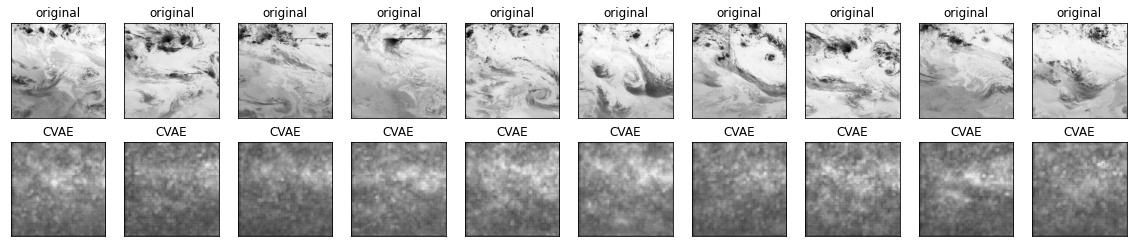

In [6]:
# Test plot
%matplotlib inline
import matplotlib.pyplot as plt

x = read_multiple_preprocessed_noaagridsatb1(samples['xuri'])
print(x.shape)
cvaex = cvae(x)
print(cvaex.shape)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x[i,:,:,0])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(cvaex[i,:,:,0])
    plt.title("CVAE")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [7]:
cvae.save('../workspace/cvae')

INFO:tensorflow:Assets written to: ../workspace/cvae\assets
